In [22]:
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt 
import numpy as np

from cvae_no_condition import CVAE
from data import Conditional

In [2]:
tst = Conditional(add_condition=False, data_size=10000, dependent_func=torch.log)
tst.setup()
test_data = tst.test_dataloader().dataset

In [57]:
# cuda setup
device = torch.device("cuda")
kwargs = {'num_workers': 1, 'pin_memory': True} 

# hyper params
batch_size = 64
latent_size = 32
epochs = 10
# class_size = 3

# create a CVAE model
model = CVAE(12*2, latent_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

tst = Conditional(add_condition=False, data_size=20000, dependent_func=torch.log)
tst.setup()
test_data = tst.test_dataloader().dataset

train_loader = tst.train_dataloader()
test_loader = tst.test_dataloader()


def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label-1] = 1
        # targets = torch.nn.functional.softmax(targets, dim=1)
    return targets.to(device)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    # BCE = torch.nn.functional.binary_cross_entropy(recon_x, x.flatten(1), reduction='sum')
    MSE = torch.nn.functional.mse_loss(input=recon_x, target=x.flatten(1), reduction='mean')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1))
    return MSE + 0.01*KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        # labels = one_hot(labels, class_size)
        recon_batch, mu, logvar = model(data)
        # print('!!!!', recon_batch.shape, data.shape)
        optimizer.zero_grad()
        loss = loss_function(recon_x=recon_batch, x=data, mu=mu, logvar=logvar)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            # labels = one_hot(labels, class_size)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).detach().cpu().numpy()
            # if i == 0:
            #     n = min(data.size(0), 5)
                # comparison = torch.cat([data[:n],
                #                       recon_batch.view(-1, 12, 28)[:n]])
                # save_image(comparison.cpu(),
                #          'reconstruction_' + str(f"{epoch:02}") + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [58]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    # with torch.no_grad():
    #     c = torch.eye(15, 15).cuda()
    #     sample = torch.randn(15, latent_size).to(device)
    #     sample = model.decode(sample, c).cpu()
        # save_image(sample.view(10, 1, 28, 28),
        #             'sample_' + str(f"{epoch:02}") + '.png')


Train Epoch: 1 [0/16000 (0%)]	Loss: 0.012929
Train Epoch: 1 [2560/16000 (16%)]	Loss: 0.007645
Train Epoch: 1 [5120/16000 (32%)]	Loss: 0.008422
Train Epoch: 1 [7680/16000 (48%)]	Loss: 0.007637
Train Epoch: 1 [10240/16000 (64%)]	Loss: 0.007531
Train Epoch: 1 [12800/16000 (80%)]	Loss: 0.007521
Train Epoch: 1 [15360/16000 (96%)]	Loss: 0.007590
====> Epoch: 1 Average loss: 0.0081
====> Test set loss: 0.0003
Train Epoch: 2 [0/16000 (0%)]	Loss: 0.007978
Train Epoch: 2 [2560/16000 (16%)]	Loss: 0.008031
Train Epoch: 2 [5120/16000 (32%)]	Loss: 0.008279
Train Epoch: 2 [7680/16000 (48%)]	Loss: 0.007631
Train Epoch: 2 [10240/16000 (64%)]	Loss: 0.007616
Train Epoch: 2 [12800/16000 (80%)]	Loss: 0.008211
Train Epoch: 2 [15360/16000 (96%)]	Loss: 0.007875
====> Epoch: 2 Average loss: 0.0079
====> Test set loss: 0.0002
Train Epoch: 3 [0/16000 (0%)]	Loss: 0.007609
Train Epoch: 3 [2560/16000 (16%)]	Loss: 0.007673
Train Epoch: 3 [5120/16000 (32%)]	Loss: 0.007913
Train Epoch: 3 [7680/16000 (48%)]	Loss: 0.007

In [59]:
# condition_class = 1

# dd = []
# for d, l in test_data:
#     if l == condition_class:
#         dd.append(d)
# dd = torch.stack(dd)

sample_len = len(test_data)



# c = torch.eye(15, 15).cuda()
# c = one_hot(torch.tensor([condition_class]).repeat(sample_len, 1), class_size=class_size)
sample = torch.randn(sample_len, latent_size).to(device)
sample = model.decode(sample).detach().cpu().view(-1, 12, 2)

In [60]:
sample.shape

torch.Size([4000, 12, 2])

In [52]:
test_data.shape

torch.Size([4000, 12, 2])

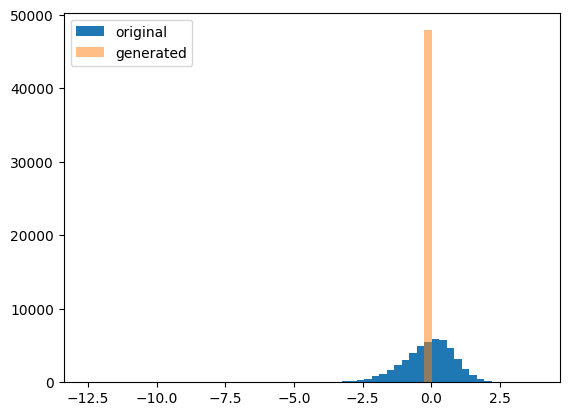

In [61]:
hist_vals_original, bin_edges = np.histogram(test_data[:, :, 1].flatten(), bins=60)
hist_vals_generated, bin_edges = np.histogram(sample[:, :, 1].flatten(), bins=bin_edges[:-1])

plt.bar(x=bin_edges, height=hist_vals_original, width=bin_edges[1]-bin_edges[0], alpha=1, label='original')
plt.bar(x=bin_edges[:-1], height=hist_vals_generated, width=bin_edges[1]-bin_edges[0], alpha=0.5, label='generated')
plt.legend()

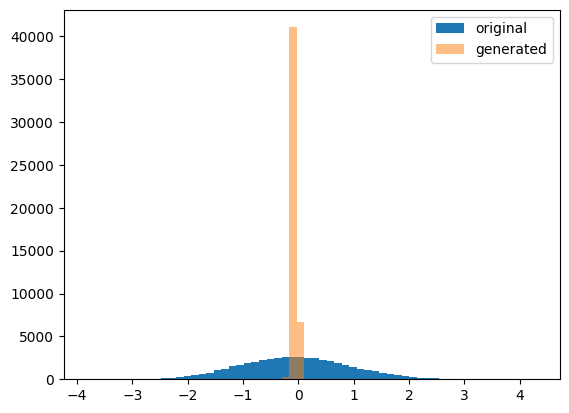

In [62]:
hist_vals_original, bin_edges = np.histogram(test_data[:, :, 0].flatten(), bins=60)
hist_vals_generated, bin_edges = np.histogram(sample[:, :, 0].flatten(), bins=bin_edges[:-1])

plt.bar(x=bin_edges, height=hist_vals_original, width=bin_edges[1]-bin_edges[0], alpha=1, label='original')
plt.bar(x=bin_edges[:-1], height=hist_vals_generated, width=bin_edges[1]-bin_edges[0], alpha=0.5, label='generated')
plt.legend()

In [46]:
tst = Conditional(add_condition=True, dependent_func=torch.cos, data_size=5000, 
                  seq_len=4,
                #   transforms=None,
                  )
tst.setup()
train_data = tst.train_dataloader().dataset

dd_1 = []
dd_2 = []
dd_3 = []
dd = []
ll=[]
for d, l in train_data:
    dd.append(d)
    if l == 1:
        dd_1.append(d)
    elif l == 2:
        dd_2.append(d)
    else:
        dd_3.append(d)
dd_1 = torch.stack(dd_1)
dd_2 = torch.stack(dd_2)
dd_3 = torch.stack(dd_3)
dd = torch.stack(dd)
# ll = torch.stack(ll)

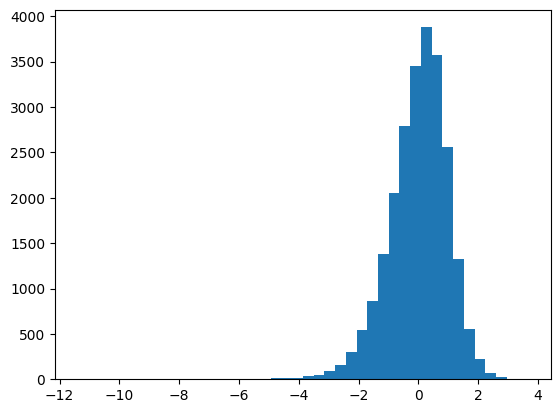

In [6]:
plt.hist(test_data[:, :, 1].flatten(), bins=42);

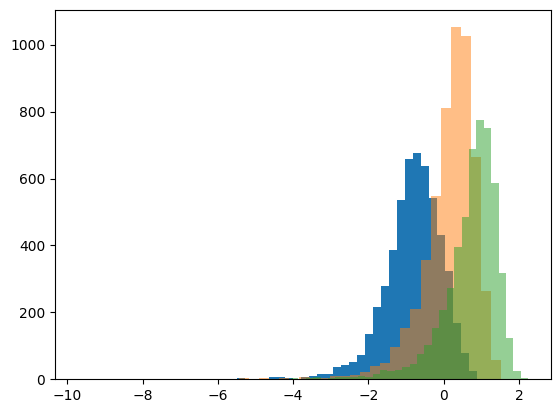

In [35]:
plt.hist(dd_1[:, :, 1].flatten(), bins=42)
plt.hist(dd_2[:, :, 1].flatten(), bins=42, alpha=0.5)
plt.hist(dd_3[:, :, 1].flatten(), bins=42, alpha=0.5);
# plt.hist(dd[:, :, 1].flatten(), bins=42, alpha=0.5);

In [25]:
dd_1.shape

torch.Size([1388, 4, 2])

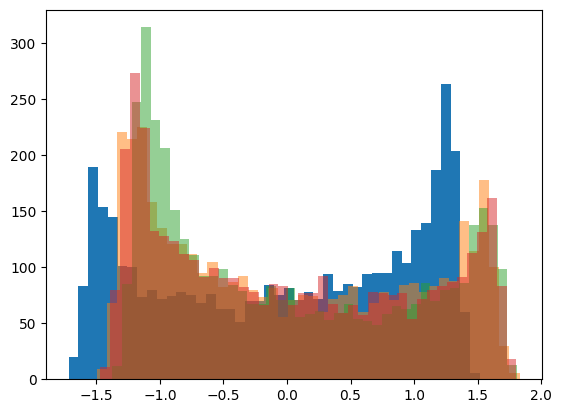

In [47]:
plt.hist(dd[:, 0, 1].flatten(), bins=42)
plt.hist(dd[:, 1, 1].flatten(), bins=42, alpha=0.5)
plt.hist(dd[:, 2, 1].flatten(), bins=42, alpha=0.5);
plt.hist(dd[:, 3, 1].flatten(), bins=42, alpha=0.5);


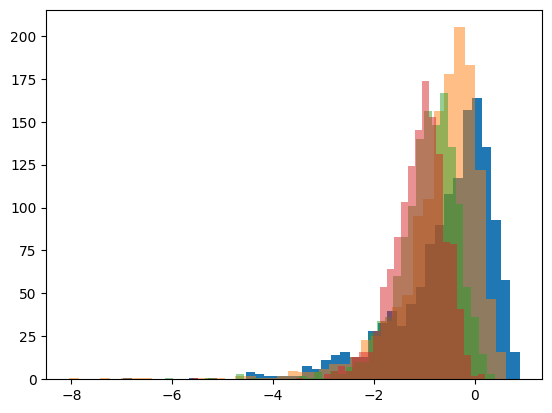

In [36]:
plt.hist(dd_1[:, 0, 1].flatten(), bins=42)
plt.hist(dd_1[:, 1, 1].flatten(), bins=42, alpha=0.5)
plt.hist(dd_1[:, 2, 1].flatten(), bins=42, alpha=0.5);
plt.hist(dd_1[:, 3, 1].flatten(), bins=42, alpha=0.5);


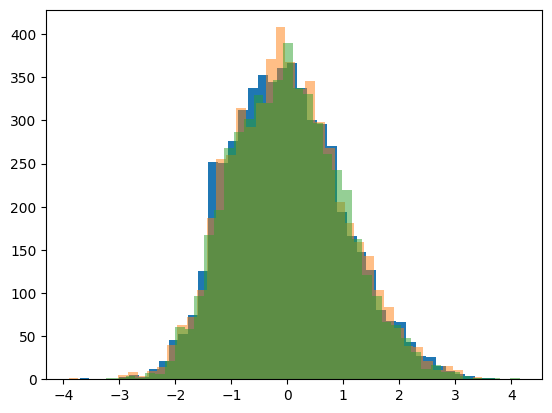

In [37]:
plt.hist(dd_1[:, :, 0].flatten(), bins=42)
plt.hist(dd_2[:, :, 0].flatten(), bins=42, alpha=0.5)
plt.hist(dd_3[:, :, 0].flatten(), bins=42, alpha=0.5);